In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 KB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.0 MB/s eta 0:00:00


 # **IPL SCORE PREDICTION**


# Import the Libraries

In [2]:
#Import necessary libraries
import pandas as pd
import numpy as np
import optuna
import seaborn as sns
import matplotlib.pyplot as plt 

# Load the Dataset

In [3]:
# Loading the dataset
ipl_df = pd.read_csv("https://github.com/zep-analytics/IPLScorePredictor/blob/main/ipl_data.csv?raw=true")
ipl_df.head()

,mid,date,venue,bat_team,bowl_team,batsman,bowler,runs,wickets,overs,runs_last_5,wickets_last_5,striker,non-striker,total
0,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,P Kumar,1,0,0.1,1,0,0,0,222
1,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,1,0,0.2,1,0,0,0,222
2,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.2,2,0,0,0,222
3,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.3,2,0,0,0,222
4,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.4,2,0,0,0,222


In [4]:
ipl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76014 entries, 0 to 76013
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   mid             76014 non-null  int64  
 1   date            76014 non-null  object 
 2   venue           76014 non-null  object 
 3   bat_team        76014 non-null  object 
 4   bowl_team       76014 non-null  object 
 5   batsman         76014 non-null  object 
 6   bowler          76014 non-null  object 
 7   runs            76014 non-null  int64  
 8   wickets         76014 non-null  int64  
 9   overs           76014 non-null  float64
 10  runs_last_5     76014 non-null  int64  
 11  wickets_last_5  76014 non-null  int64  
 12  striker         76014 non-null  int64  
 13  non-striker     76014 non-null  int64  
 14  total           76014 non-null  int64  
dtypes: float64(1), int64(8), object(6)
memory usage: 8.7+ MB


# Data Pre-processing


1. Check for Null Values

In [5]:
# Check for Null Values
ipl_df.isnull().sum()

mid               0
date              0
venue             0
bat_team          0
bowl_team         0
batsman           0
bowler            0
runs              0
wickets           0
overs             0
runs_last_5       0
wickets_last_5    0
striker           0
non-striker       0
total             0
dtype: int64

2. Convert Date type from String to date

In [6]:
#Convert Date type from string to date
ipl_df['date'] = pd.to_datetime(ipl_df['date'])

In [7]:
ipl_df.shape

(76014, 15)

3. Drop Unnecessary Columns

As mid, striker, non-striker, batsman , bowler and venue are not needed for Score Prediction

In [8]:
# Drop the unecessary columns: mid, striker, non striker, venue, batsman, bowler
columns_to_drop = ['mid', 'striker', 'non-striker','batsman', 'bowler', 'venue']
ipl_df.drop(columns_to_drop, axis = 1, inplace = True)
ipl_df.head()

,date,bat_team,bowl_team,runs,wickets,overs,runs_last_5,wickets_last_5,total
0,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,1,0,0.1,1,0,222
1,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,1,0,0.2,1,0,222
2,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.2,2,0,222
3,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.3,2,0,222
4,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.4,2,0,222


4. Get Details of Current Team

In [9]:
# Get the teams
list(ipl_df['bat_team'].unique())

['Kolkata Knight Riders',
 'Chennai Super Kings',
 'Rajasthan Royals',
 'Mumbai Indians',
 'Deccan Chargers',
 'Kings XI Punjab',
 'Royal Challengers Bangalore',
 'Delhi Daredevils',
 'Kochi Tuskers Kerala',
 'Pune Warriors',
 'Sunrisers Hyderabad',
 'Rising Pune Supergiants',
 'Gujarat Lions',
 'Rising Pune Supergiant']

Teams 'Deccan Chargers', 'Kochi Tuskers Kerala', 'Gujarat Lions', 'Kochi Tuskers Kerala', 'Rising Pune Supergiant', 'Pune Warriors', 'Rising Pune Supergiants' are currenty either plays with different name or doesnt, so we just remove them and their data

In [10]:
# Remove old teams
team_list = list(ipl_df['bat_team'].unique())
old_teams = ['Deccan Chargers', 'Kochi Tuskers Kerala', 'Gujarat Lions', 'Kochi Tuskers Kerala', 'Rising Pune Supergiant', 'Pune Warriors', 'Rising Pune Supergiants']


In [11]:
#Get only current team and its data
current_teams = [teams for teams in team_list if teams not in old_teams] 

# Use the rows which have current_teams
ipl_df = ipl_df[ipl_df['bat_team'].isin(current_teams) & ipl_df['bowl_team'].isin(current_teams)]

In [12]:
ipl_df.head()

,date,bat_team,bowl_team,runs,wickets,overs,runs_last_5,wickets_last_5,total
0,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,1,0,0.1,1,0,222
1,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,1,0,0.2,1,0,222
2,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.2,2,0,222
3,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.3,2,0,222
4,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.4,2,0,222


In [13]:
#Check the team list with old teams removed
list(ipl_df['bat_team'].unique())

['Kolkata Knight Riders',
 'Chennai Super Kings',
 'Rajasthan Royals',
 'Mumbai Indians',
 'Kings XI Punjab',
 'Royal Challengers Bangalore',
 'Delhi Daredevils',
 'Sunrisers Hyderabad']

# Exploratory Data Analysis

In [14]:
ipl_df.head()

,date,bat_team,bowl_team,runs,wickets,overs,runs_last_5,wickets_last_5,total
0,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,1,0,0.1,1,0,222
1,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,1,0,0.2,1,0,222
2,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.2,2,0,222
3,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.3,2,0,222
4,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.4,2,0,222


Wicket Distribution

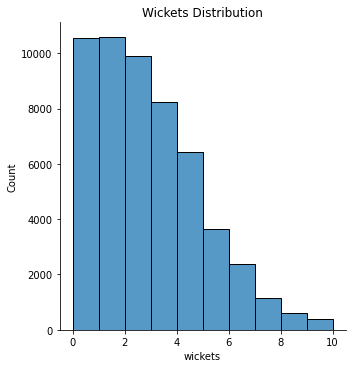

In [15]:
sns.displot(ipl_df['wickets'],kde=False,bins=10)
plt.title("Wickets Distribution")

plt.show()

Most of the wickets are between 0 to 3

Runs Distribution

* Lie between 150 to 175

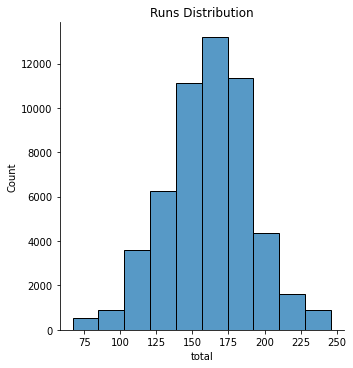

In [16]:
sns.displot(ipl_df['total'],kde=False,bins=10)
plt.title("Runs Distribution")

plt.show()

Correlation between variables

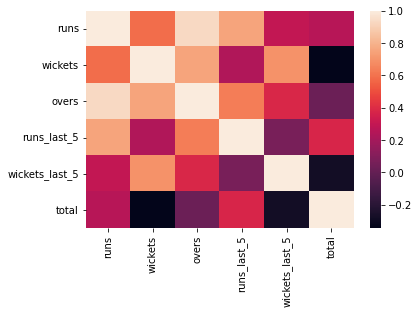

In [17]:
# Check the correlation betweeen the numerical features
corr = ipl_df.corr()


# Plot the heatmaps using seaborn
sns.heatmap(corr)

In [18]:
corr

,runs,wickets,overs,runs_last_5,wickets_last_5,total
runs,1.000000,0.585470,0.936672,0.756638,0.298999,0.260193
wickets,0.585470,1.000000,0.753480,0.240959,0.696528,-0.345314
overs,0.936672,0.753480,1.000000,0.633673,0.384388,0.025120
runs_last_5,0.756638,0.240959,0.633673,1.000000,0.067445,0.375733
wickets_last_5,0.298999,0.696528,0.384388,0.067445,1.000000,-0.277322
total,0.260193,-0.345314,0.025120,0.375733,-0.277322,1.000000


<b>RUNS, WICKETS</b> are highly correlated with OVERS.


# Prepare Data

Encode Categorical Columns
 * To Encode Categorical Columns here we will use OneHot Encoder


In [19]:
# get all the categorial columns
categorial_features = ['bat_team', 'bowl_team']

In [20]:
# Number of unique values in categorial_features

for cols in categorial_features:
    n_unique = np.unique(ipl_df[cols]).shape[0]
    print("Unique values in %s column is %d"%(cols, n_unique))

Unique values in bat_team column is 8
Unique values in bowl_team column is 8


In [21]:
#bat_team bowl_team features are few apply onehot encoder
nominal_cols = ['bat_team', 'bowl_team'] # onehot encode these columns

# One hot encode the columns and concat using pd.concat
ipl_df = pd.concat((ipl_df, pd.get_dummies(ipl_df[nominal_cols])), axis = 1)
ipl_df.head()

,date,bat_team,bowl_team,runs,wickets,overs,runs_last_5,wickets_last_5,total,bat_team_Chennai Super Kings,...,bat_team_Royal Challengers Bangalore,bat_team_Sunrisers Hyderabad,bowl_team_Chennai Super Kings,bowl_team_Delhi Daredevils,bowl_team_Kings XI Punjab,bowl_team_Kolkata Knight Riders,bowl_team_Mumbai Indians,bowl_team_Rajasthan Royals,bowl_team_Royal Challengers Bangalore,bowl_team_Sunrisers Hyderabad
0,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,1,0,0.1,1,0,222,0,...,0,0,0,0,0,0,0,0,1,0
1,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,1,0,0.2,1,0,222,0,...,0,0,0,0,0,0,0,0,1,0
2,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.2,2,0,222,0,...,0,0,0,0,0,0,0,0,1,0
3,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.3,2,0,222,0,...,0,0,0,0,0,0,0,0,1,0
4,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.4,2,0,222,0,...,0,0,0,0,0,0,0,0,1,0


In [22]:
# Since, the nominal columns have been encoded drop its actual columns
ipl_df.drop(nominal_cols, axis = 1, inplace = True)

In [23]:
ipl_df.head()

,date,runs,wickets,overs,runs_last_5,wickets_last_5,total,bat_team_Chennai Super Kings,bat_team_Delhi Daredevils,bat_team_Kings XI Punjab,...,bat_team_Royal Challengers Bangalore,bat_team_Sunrisers Hyderabad,bowl_team_Chennai Super Kings,bowl_team_Delhi Daredevils,bowl_team_Kings XI Punjab,bowl_team_Kolkata Knight Riders,bowl_team_Mumbai Indians,bowl_team_Rajasthan Royals,bowl_team_Royal Challengers Bangalore,bowl_team_Sunrisers Hyderabad
0,2008-04-18,1,0,0.1,1,0,222,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2008-04-18,1,0,0.2,1,0,222,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2008-04-18,2,0,0.2,2,0,222,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2008-04-18,2,0,0.3,2,0,222,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,2008-04-18,2,0,0.4,2,0,222,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Split the Dataset

In [24]:
# Split the data into training and testing set by year 2008 to 2020, take mid year value 
train_set = ipl_df[ipl_df['date'].dt.year <= 2014]
test_set = ipl_df[ipl_df['date'].dt.year > 2014]

print('Shape of training set is %d, %d'%(train_set.shape[0], train_set.shape[1]))
print('Shape of testing set is %d, %d'%(test_set.shape[0], test_set.shape[1]))


Shape of training set is 39553, 23
Shape of testing set is 14258, 23


In [25]:
# Drop the date columns since its not needed here for modelling
train_set.drop(['date'], axis = 1, inplace = True)
test_set.drop(['date'], axis = 1, inplace = True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Standardize the Data

In [26]:
# Performing the standardization on the train and test set
from sklearn.preprocessing import StandardScaler

# Fit the standard scaler
for column in train_set.columns:
  
  if column != 'total':
 
    ss = StandardScaler()
    # Fit every column
    train_set[column] = ss.fit_transform(train_set[column].values.reshape((-1,1)))
'''(X-X.mean())/X.std()'''


for column in test_set.columns:

  if column != 'total':
   
    ss = StandardScaler()
    # Fit every column
    test_set[column] = ss.fit_transform(test_set[column].values.reshape((-1,1)))

<ipython-input-26-f1f15013d54c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set[column] = ss.fit_transform(train_set[column].values.reshape((-1,1)))
<ipython-input-26-f1f15013d54c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set[column] = ss.fit_transform(train_set[column].values.reshape((-1,1)))
<ipython-input-26-f1f15013d54c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [27]:
train_set.head()

,runs,wickets,overs,runs_last_5,wickets_last_5,total,bat_team_Chennai Super Kings,bat_team_Delhi Daredevils,bat_team_Kings XI Punjab,bat_team_Kolkata Knight Riders,...,bat_team_Royal Challengers Bangalore,bat_team_Sunrisers Hyderabad,bowl_team_Chennai Super Kings,bowl_team_Delhi Daredevils,bowl_team_Kings XI Punjab,bowl_team_Kolkata Knight Riders,bowl_team_Mumbai Indians,bowl_team_Rajasthan Royals,bowl_team_Royal Challengers Bangalore,bowl_team_Sunrisers Hyderabad
0,-1.503409,-1.208394,-1.675117,-2.141963,-1.061525,222,-0.430077,-0.349842,-0.416038,2.704569,...,-0.368551,-0.237921,-0.391127,-0.41967,-0.36771,-0.402396,-0.394215,-0.398358,2.349333,-0.188343
1,-1.503409,-1.208394,-1.657796,-2.141963,-1.061525,222,-0.430077,-0.349842,-0.416038,2.704569,...,-0.368551,-0.237921,-0.391127,-0.41967,-0.36771,-0.402396,-0.394215,-0.398358,2.349333,-0.188343
2,-1.482893,-1.208394,-1.657796,-2.074966,-1.061525,222,-0.430077,-0.349842,-0.416038,2.704569,...,-0.368551,-0.237921,-0.391127,-0.41967,-0.36771,-0.402396,-0.394215,-0.398358,2.349333,-0.188343
3,-1.482893,-1.208394,-1.640474,-2.074966,-1.061525,222,-0.430077,-0.349842,-0.416038,2.704569,...,-0.368551,-0.237921,-0.391127,-0.41967,-0.36771,-0.402396,-0.394215,-0.398358,2.349333,-0.188343
4,-1.482893,-1.208394,-1.623152,-2.074966,-1.061525,222,-0.430077,-0.349842,-0.416038,2.704569,...,-0.368551,-0.237921,-0.391127,-0.41967,-0.36771,-0.402396,-0.394215,-0.398358,2.349333,-0.188343


In [28]:
test_set.head()

,runs,wickets,overs,runs_last_5,wickets_last_5,total,bat_team_Chennai Super Kings,bat_team_Delhi Daredevils,bat_team_Kings XI Punjab,bat_team_Kolkata Knight Riders,...,bat_team_Royal Challengers Bangalore,bat_team_Sunrisers Hyderabad,bowl_team_Chennai Super Kings,bowl_team_Delhi Daredevils,bowl_team_Kings XI Punjab,bowl_team_Kolkata Knight Riders,bowl_team_Mumbai Indians,bowl_team_Rajasthan Royals,bowl_team_Royal Challengers Bangalore,bowl_team_Sunrisers Hyderabad
55226,-1.536359,-1.164183,-1.675832,-2.265271,-1.063397,168,-0.324983,-0.369034,-0.410134,-0.348357,...,-0.41711,-0.472586,-0.234968,-0.444237,-0.400634,2.117509,-0.445481,-0.273899,-0.372216,-0.342762
55227,-1.516648,-1.164183,-1.658518,-2.199982,-1.063397,168,-0.324983,-0.369034,-0.410134,-0.348357,...,-0.41711,-0.472586,-0.234968,-0.444237,-0.400634,2.117509,-0.445481,-0.273899,-0.372216,-0.342762
55228,-1.496937,-1.164183,-1.641205,-2.134693,-1.063397,168,-0.324983,-0.369034,-0.410134,-0.348357,...,-0.41711,-0.472586,-0.234968,-0.444237,-0.400634,2.117509,-0.445481,-0.273899,-0.372216,-0.342762
55229,-1.477226,-1.164183,-1.623891,-2.069403,-1.063397,168,-0.324983,-0.369034,-0.410134,-0.348357,...,-0.41711,-0.472586,-0.234968,-0.444237,-0.400634,2.117509,-0.445481,-0.273899,-0.372216,-0.342762
55230,-1.457515,-1.164183,-1.606578,-2.004114,-1.063397,168,-0.324983,-0.369034,-0.410134,-0.348357,...,-0.41711,-0.472586,-0.234968,-0.444237,-0.400634,2.117509,-0.445481,-0.273899,-0.372216,-0.342762


In [29]:
# Split the training and testing set into X and y
X_train, y_train = train_set.drop('total', axis = 1), train_set['total']
X_test, y_test = test_set.drop('total', axis = 1), test_set['total']

In [30]:
X_train.head()

,runs,wickets,overs,runs_last_5,wickets_last_5,bat_team_Chennai Super Kings,bat_team_Delhi Daredevils,bat_team_Kings XI Punjab,bat_team_Kolkata Knight Riders,bat_team_Mumbai Indians,...,bat_team_Royal Challengers Bangalore,bat_team_Sunrisers Hyderabad,bowl_team_Chennai Super Kings,bowl_team_Delhi Daredevils,bowl_team_Kings XI Punjab,bowl_team_Kolkata Knight Riders,bowl_team_Mumbai Indians,bowl_team_Rajasthan Royals,bowl_team_Royal Challengers Bangalore,bowl_team_Sunrisers Hyderabad
0,-1.503409,-1.208394,-1.675117,-2.141963,-1.061525,-0.430077,-0.349842,-0.416038,2.704569,-0.431645,...,-0.368551,-0.237921,-0.391127,-0.41967,-0.36771,-0.402396,-0.394215,-0.398358,2.349333,-0.188343
1,-1.503409,-1.208394,-1.657796,-2.141963,-1.061525,-0.430077,-0.349842,-0.416038,2.704569,-0.431645,...,-0.368551,-0.237921,-0.391127,-0.41967,-0.36771,-0.402396,-0.394215,-0.398358,2.349333,-0.188343
2,-1.482893,-1.208394,-1.657796,-2.074966,-1.061525,-0.430077,-0.349842,-0.416038,2.704569,-0.431645,...,-0.368551,-0.237921,-0.391127,-0.41967,-0.36771,-0.402396,-0.394215,-0.398358,2.349333,-0.188343
3,-1.482893,-1.208394,-1.640474,-2.074966,-1.061525,-0.430077,-0.349842,-0.416038,2.704569,-0.431645,...,-0.368551,-0.237921,-0.391127,-0.41967,-0.36771,-0.402396,-0.394215,-0.398358,2.349333,-0.188343
4,-1.482893,-1.208394,-1.623152,-2.074966,-1.061525,-0.430077,-0.349842,-0.416038,2.704569,-0.431645,...,-0.368551,-0.237921,-0.391127,-0.41967,-0.36771,-0.402396,-0.394215,-0.398358,2.349333,-0.188343


# ML Modelling

In [31]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_squared_log_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model

from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings('ignore')


Define objective function for OPTUNA

In [34]:
def objective(trial):
    regressor_name = trial.suggest_categorical("regressor", ["KNR","XGBoost","RandomForest","LinearREgression","DT"])


    if regressor_name=="KNR":
        parameter= {
        'n_neighbors': trial.suggest_int("n_neighbors", 1, 30),
        'weights' : trial.suggest_categorical("weights", ['uniform', 'distance']),
        'metric' : trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski'])
        }
        regressor = KNeighborsRegressor(**parameter)
        regressor.fit(X_train, y_train)

    elif regressor_name=="XGBoost":
        parameter = {
      "n_estimators" : trial.suggest_int('n_estimators', 0, 500), 
      'max_depth':trial.suggest_int('max_depth', 3, 5), 
      'reg_alpha':trial.suggest_float('reg_alpha',0,6), 
      'reg_lambda':trial.suggest_float('reg_lambda',0,2), 
      'min_child_weight':trial.suggest_int('min_child_weight',0,5), 
      'gamma':trial.suggest_float('gamma', 0, 4), 
      'learning_rate':trial.suggest_float('learning_rate',0.05,0.5), 
      'colsample_bytree':trial.suggest_float('colsample_bytree',0.4,0.9), 
      'subsample':trial.suggest_float('subsample',0.4,0.9),
      'nthread' : -1
    }
        regressor = XGBRegressor(**parameter)
    
        regressor.fit(X_train, y_train)

    elif regressor_name=="RandomForest":
        parameter= { 
            "n_estimators" : trial.suggest_int('n_estimators', 0, 500), # show integer parameters between 0 and 500 for estimators
            'max_depth':trial.suggest_int('depth', 3, 5), # show integer parameters between 3 and 5 for depth
            "max_features": trial.suggest_categorical("max_feature", ['auto', 'sqrt']),
            "min_samples_split":trial.suggest_int("max_leaf",2,10),
            "min_samples_leaf": trial.suggest_int("min_samp",1,5),
            "bootstrap": trial.suggest_categorical("bootstrap",[True,False]) 
            
        }
        regressor = RandomForestRegressor(**parameter)
    
        regressor.fit(X_train, y_train)
    
    elif regressor_name=="LinearRegression":
        parameter={
            "fit_intercept" : trial.suggest_categorical('fit_intercept',['True','False']),
            "copy_X" : trial.suggest_categorical('copy_X',['True','False']),
            "positive" : trial.suggest_categorical('positive',['True','False']),
            
        }
        regressor = LinearRegresssion()
    
        regressor.fit(X_train, y_train)


    else:        
        parameter= { 
            "criterion": trial.suggest_categorical("criterion", ["absolute_error", "friedman_mse","squared_error", "poisson"]),
            "splitter": trial.suggest_categorical("splitter", ['best', 'random']),
            "max_depth": trial.suggest_int("depth",2,200),
            "min_samples_split":trial.suggest_int("max_leaf",2,100),
            # "min_weight_fraction_leaf": trial.suggest_float("min_samp",0,1),
            "max_features": trial.suggest_categorical("max_features",["auto","sqrt","log2"]) 
            
        }
        regressor = DecisionTreeRegressor(**parameter)
    
        regressor.fit(X_train, y_train)
    

     

    pred=regressor.predict(X_test)
    
    # Mean Absolute Error to evaluate the performance 
    
    mae = mean_absolute_error(y_test, pred)
    

    
    return mae

In [35]:
%%time

study = optuna.create_study(study_name="Model",direction="minimize",sampler=TPESampler())
study.optimize(objective, n_trials=100)

[I 2023-02-19 09:04:27,953] A new study created in memory with name: Model


[09:04:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:04:28,285] Trial 0 finished with value: 18.136390085657776 and parameters: {'regressor': 'XGBoost', 'n_estimators': 9, 'max_depth': 3, 'reg_alpha': 4.2103166701001395, 'reg_lambda': 1.7474981894201915, 'min_child_weight': 3, 'gamma': 1.5751362862644362, 'learning_rate': 0.44785047565194613, 'colsample_bytree': 0.7827009908085285, 'subsample': 0.7158832357528985}. Best is trial 0 with value: 18.136390085657776.
[I 2023-02-19 09:04:28,548] Trial 1 finished with value: 20.091223536809746 and parameters: {'regressor': 'RandomForest', 'n_estimators': 9, 'depth': 3, 'max_feature': 'auto', 'max_leaf': 10, 'min_samp': 5, 'bootstrap': True}. Best is trial 0 with value: 18.136390085657776.
[I 2023-02-19 09:05:24,468] Trial 2 finished with value: 22.79341422359377 and parameters: {'regressor': 'DT', 'criterion': 'absolute_error', 'splitter': 'best', 'depth': 135, 'max_leaf': 6, 'max_features': 'auto'}. Best is trial 0 with value: 18.136390085657776.


[09:05:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:05:30,570] Trial 3 finished with value: 17.98543972861367 and parameters: {'regressor': 'XGBoost', 'n_estimators': 107, 'max_depth': 5, 'reg_alpha': 2.536427107818786, 'reg_lambda': 1.9186649921247614, 'min_child_weight': 3, 'gamma': 1.6548728947990345, 'learning_rate': 0.31096000544560204, 'colsample_bytree': 0.8752270968010983, 'subsample': 0.7591955080209623}. Best is trial 3 with value: 17.98543972861367.
[I 2023-02-19 09:05:38,769] Trial 4 finished with value: 25.297659543162226 and parameters: {'regressor': 'KNR', 'n_neighbors': 17, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 3 with value: 17.98543972861367.
[I 2023-02-19 09:05:38,915] Trial 5 finished with value: 19.700643223146773 and parameters: {'regressor': 'DT', 'criterion': 'squared_error', 'splitter': 'best', 'depth': 194, 'max_leaf': 65, 'max_features': 'auto'}. Best is trial 3 with value: 17.98543972861367.
[I 2023-02-19 09:05:48,050] Trial 6 finished with value: 25.524903008495734 and 

[09:06:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:06:17,522] Trial 9 finished with value: 19.699806350630954 and parameters: {'regressor': 'XGBoost', 'n_estimators': 391, 'max_depth': 5, 'reg_alpha': 3.2931217879741776, 'reg_lambda': 0.642952904126685, 'min_child_weight': 2, 'gamma': 0.3635998101750255, 'learning_rate': 0.45364374591632173, 'colsample_bytree': 0.722780864034869, 'subsample': 0.6828914940406297}. Best is trial 3 with value: 17.98543972861367.
[I 2023-02-19 09:06:17,573] Trial 10 finished with value: 23.238931088206673 and parameters: {'regressor': 'LinearREgression', 'criterion': 'poisson', 'splitter': 'random', 'depth': 86, 'max_leaf': 98, 'max_features': 'sqrt'}. Best is trial 3 with value: 17.98543972861367.


[09:06:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:06:17,867] Trial 11 finished with value: 23.15017350349742 and parameters: {'regressor': 'XGBoost', 'n_estimators': 7, 'max_depth': 3, 'reg_alpha': 3.6200571723018014, 'reg_lambda': 1.9513176097253173, 'min_child_weight': 4, 'gamma': 2.084037699989472, 'learning_rate': 0.3182054871399159, 'colsample_bytree': 0.8783889379637503, 'subsample': 0.7674176221438336}. Best is trial 3 with value: 17.98543972861367.


[09:06:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:06:25,764] Trial 12 finished with value: 17.693021049504864 and parameters: {'regressor': 'XGBoost', 'n_estimators': 160, 'max_depth': 5, 'reg_alpha': 1.0175366005544624, 'reg_lambda': 1.8751805558441668, 'min_child_weight': 3, 'gamma': 1.7600886612690914, 'learning_rate': 0.16502765623512855, 'colsample_bytree': 0.8655875064122347, 'subsample': 0.8258361443814595}. Best is trial 12 with value: 17.693021049504864.


[09:06:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:06:34,512] Trial 13 finished with value: 17.58974230602156 and parameters: {'regressor': 'XGBoost', 'n_estimators': 187, 'max_depth': 5, 'reg_alpha': 0.4773062881826603, 'reg_lambda': 1.5045142944156407, 'min_child_weight': 0, 'gamma': 3.939067739472708, 'learning_rate': 0.1491140066889447, 'colsample_bytree': 0.8960241067333073, 'subsample': 0.8982927481367693}. Best is trial 13 with value: 17.58974230602156.


[09:06:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:06:42,642] Trial 14 finished with value: 17.508039090021043 and parameters: {'regressor': 'XGBoost', 'n_estimators': 274, 'max_depth': 5, 'reg_alpha': 0.052001491722214355, 'reg_lambda': 1.2737562570116572, 'min_child_weight': 0, 'gamma': 3.986057439925772, 'learning_rate': 0.10477716968106308, 'colsample_bytree': 0.5867870260320646, 'subsample': 0.8979206725508551}. Best is trial 14 with value: 17.508039090021043.
[I 2023-02-19 09:06:42,729] Trial 15 finished with value: 22.31738433535097 and parameters: {'regressor': 'LinearREgression', 'criterion': 'friedman_mse', 'splitter': 'random', 'depth': 77, 'max_leaf': 46, 'max_features': 'log2'}. Best is trial 14 with value: 17.508039090021043.


[09:06:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:06:55,308] Trial 16 finished with value: 17.04098963326133 and parameters: {'regressor': 'XGBoost', 'n_estimators': 367, 'max_depth': 4, 'reg_alpha': 0.004003688097063751, 'reg_lambda': 1.142203626041625, 'min_child_weight': 0, 'gamma': 3.991477743330709, 'learning_rate': 0.0563402675122395, 'colsample_bytree': 0.5668851094680167, 'subsample': 0.8718639967769458}. Best is trial 16 with value: 17.04098963326133.


[09:06:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:07:06,747] Trial 17 finished with value: 16.965529337088512 and parameters: {'regressor': 'XGBoost', 'n_estimators': 351, 'max_depth': 4, 'reg_alpha': 0.19980207021692786, 'reg_lambda': 1.1628923075066997, 'min_child_weight': 0, 'gamma': 3.962896067537356, 'learning_rate': 0.06064356694402696, 'colsample_bytree': 0.5393533842637848, 'subsample': 0.5344905412367167}. Best is trial 17 with value: 16.965529337088512.


[09:07:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:07:20,637] Trial 18 finished with value: 17.195873498080537 and parameters: {'regressor': 'XGBoost', 'n_estimators': 489, 'max_depth': 4, 'reg_alpha': 1.5717508680469083, 'reg_lambda': 0.9868633707208994, 'min_child_weight': 1, 'gamma': 3.281369370137405, 'learning_rate': 0.0663650183263935, 'colsample_bytree': 0.47126639677666926, 'subsample': 0.5462038862189098}. Best is trial 17 with value: 16.965529337088512.
[I 2023-02-19 09:07:25,279] Trial 19 finished with value: 20.218431093929077 and parameters: {'regressor': 'RandomForest', 'n_estimators': 328, 'depth': 4, 'max_feature': 'sqrt', 'max_leaf': 2, 'min_samp': 3, 'bootstrap': False}. Best is trial 17 with value: 16.965529337088512.
[I 2023-02-19 09:07:25,343] Trial 20 finished with value: 22.571297649395735 and parameters: {'regressor': 'LinearREgression', 'criterion': 'squared_error', 'splitter': 'best', 'depth': 200, 'max_leaf': 46, 'max_features': 'log2'}. Best is trial 17 with value: 16.965529337088512.


[09:07:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:07:39,912] Trial 21 finished with value: 17.093064697047307 and parameters: {'regressor': 'XGBoost', 'n_estimators': 500, 'max_depth': 4, 'reg_alpha': 1.3517173638509932, 'reg_lambda': 0.9968137483260762, 'min_child_weight': 1, 'gamma': 3.7080806833452318, 'learning_rate': 0.06518784707699578, 'colsample_bytree': 0.47619928566596853, 'subsample': 0.5335647811846667}. Best is trial 17 with value: 16.965529337088512.


[09:07:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:07:54,199] Trial 22 finished with value: 17.098634709414267 and parameters: {'regressor': 'XGBoost', 'n_estimators': 494, 'max_depth': 4, 'reg_alpha': 0.05881861490683718, 'reg_lambda': 0.9798885034338366, 'min_child_weight': 1, 'gamma': 3.422289569752364, 'learning_rate': 0.05564202437369707, 'colsample_bytree': 0.5077915542356626, 'subsample': 0.5248335240230362}. Best is trial 17 with value: 16.965529337088512.


[09:07:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:08:04,916] Trial 23 finished with value: 17.185236926165082 and parameters: {'regressor': 'XGBoost', 'n_estimators': 394, 'max_depth': 4, 'reg_alpha': 1.3988544968306849, 'reg_lambda': 1.1586669283540543, 'min_child_weight': 0, 'gamma': 3.3543843040533385, 'learning_rate': 0.05073976880139715, 'colsample_bytree': 0.40764484275990676, 'subsample': 0.42500671595020373}. Best is trial 17 with value: 16.965529337088512.


[09:08:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:08:17,929] Trial 24 finished with value: 17.678842934372884 and parameters: {'regressor': 'XGBoost', 'n_estimators': 408, 'max_depth': 4, 'reg_alpha': 5.984769757417398, 'reg_lambda': 0.6733081075560183, 'min_child_weight': 1, 'gamma': 3.9544145629148075, 'learning_rate': 0.14428474635311828, 'colsample_bytree': 0.5771302571821255, 'subsample': 0.5974034130693804}. Best is trial 17 with value: 16.965529337088512.
[I 2023-02-19 09:08:17,973] Trial 25 finished with value: 20.469847971918686 and parameters: {'regressor': 'DT', 'criterion': 'friedman_mse', 'splitter': 'random', 'depth': 137, 'max_leaf': 99, 'max_features': 'sqrt'}. Best is trial 17 with value: 16.965529337088512.


[09:08:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:08:28,080] Trial 26 finished with value: 17.884958676827676 and parameters: {'regressor': 'XGBoost', 'n_estimators': 313, 'max_depth': 4, 'reg_alpha': 0.7620543416675919, 'reg_lambda': 0.0038711089671099597, 'min_child_weight': 0, 'gamma': 3.0835070108650298, 'learning_rate': 0.2035074418283187, 'colsample_bytree': 0.5574685326805671, 'subsample': 0.6297021212950745}. Best is trial 17 with value: 16.965529337088512.


[09:08:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:08:39,881] Trial 27 finished with value: 16.820383453155102 and parameters: {'regressor': 'XGBoost', 'n_estimators': 439, 'max_depth': 3, 'reg_alpha': 0.011597805640325198, 'reg_lambda': 1.4168729362083619, 'min_child_weight': 1, 'gamma': 2.7210565385592362, 'learning_rate': 0.10280155683301695, 'colsample_bytree': 0.635609089897268, 'subsample': 0.5135878599235857}. Best is trial 27 with value: 16.820383453155102.


[09:08:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:08:51,427] Trial 28 finished with value: 16.82953637110132 and parameters: {'regressor': 'XGBoost', 'n_estimators': 426, 'max_depth': 3, 'reg_alpha': 0.051431679859739676, 'reg_lambda': 1.4528297873385805, 'min_child_weight': 2, 'gamma': 2.8453094826721395, 'learning_rate': 0.10750811196410247, 'colsample_bytree': 0.640223550470046, 'subsample': 0.46119662891595836}. Best is trial 27 with value: 16.820383453155102.


[09:08:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:09:01,380] Trial 29 finished with value: 16.838923705378328 and parameters: {'regressor': 'XGBoost', 'n_estimators': 439, 'max_depth': 3, 'reg_alpha': 0.6792997845972746, 'reg_lambda': 1.5321456157402713, 'min_child_weight': 2, 'gamma': 2.714011070207102, 'learning_rate': 0.11783764900428415, 'colsample_bytree': 0.6480659117657258, 'subsample': 0.4472689434859416}. Best is trial 27 with value: 16.820383453155102.
[I 2023-02-19 09:09:07,078] Trial 30 finished with value: 20.15103816379159 and parameters: {'regressor': 'RandomForest', 'n_estimators': 420, 'depth': 4, 'max_feature': 'sqrt', 'max_leaf': 6, 'min_samp': 1, 'bootstrap': False}. Best is trial 27 with value: 16.820383453155102.


[09:09:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:09:18,879] Trial 31 finished with value: 16.985084090097068 and parameters: {'regressor': 'XGBoost', 'n_estimators': 444, 'max_depth': 3, 'reg_alpha': 0.6627744123207865, 'reg_lambda': 1.518055038145425, 'min_child_weight': 2, 'gamma': 2.7501512419736005, 'learning_rate': 0.12154678984202039, 'colsample_bytree': 0.653587956942131, 'subsample': 0.44904917693416824}. Best is trial 27 with value: 16.820383453155102.


[09:09:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:09:30,847] Trial 32 finished with value: 16.746925025455145 and parameters: {'regressor': 'XGBoost', 'n_estimators': 450, 'max_depth': 3, 'reg_alpha': 0.006093098504256447, 'reg_lambda': 1.48757001892147, 'min_child_weight': 2, 'gamma': 2.703403026681963, 'learning_rate': 0.10857445658530585, 'colsample_bytree': 0.6467707206177699, 'subsample': 0.4635569906917351}. Best is trial 32 with value: 16.746925025455145.


[09:09:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:09:42,883] Trial 33 finished with value: 17.407262787408893 and parameters: {'regressor': 'XGBoost', 'n_estimators': 452, 'max_depth': 3, 'reg_alpha': 0.7889447639556615, 'reg_lambda': 1.5468877724497445, 'min_child_weight': 2, 'gamma': 2.6547353608677264, 'learning_rate': 0.19389097870924038, 'colsample_bytree': 0.6406897072342718, 'subsample': 0.46519909831962425}. Best is trial 32 with value: 16.746925025455145.
[I 2023-02-19 09:09:43,020] Trial 34 finished with value: 21.21009890651452 and parameters: {'regressor': 'DT', 'criterion': 'poisson', 'splitter': 'random', 'depth': 53, 'max_leaf': 65, 'max_features': 'auto'}. Best is trial 32 with value: 16.746925025455145.


[09:09:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:09:54,924] Trial 35 finished with value: 16.788992236048163 and parameters: {'regressor': 'XGBoost', 'n_estimators': 455, 'max_depth': 3, 'reg_alpha': 0.02908868953998605, 'reg_lambda': 1.6477411238635062, 'min_child_weight': 2, 'gamma': 2.6621398885427463, 'learning_rate': 0.11134676935453636, 'colsample_bytree': 0.6452603175719216, 'subsample': 0.41595494075525413}. Best is trial 32 with value: 16.746925025455145.
[I 2023-02-19 09:10:12,111] Trial 36 finished with value: 27.056108851171274 and parameters: {'regressor': 'KNR', 'n_neighbors': 2, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 32 with value: 16.746925025455145.


[09:10:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:10:24,281] Trial 37 finished with value: 16.758829781142605 and parameters: {'regressor': 'XGBoost', 'n_estimators': 465, 'max_depth': 3, 'reg_alpha': 0.019725377065670298, 'reg_lambda': 1.7271367311634507, 'min_child_weight': 2, 'gamma': 2.3448641929099967, 'learning_rate': 0.09997779100217001, 'colsample_bytree': 0.6815977455931657, 'subsample': 0.4053201852259867}. Best is trial 32 with value: 16.746925025455145.
[I 2023-02-19 09:10:41,273] Trial 38 finished with value: 23.922043764903915 and parameters: {'regressor': 'DT', 'criterion': 'absolute_error', 'splitter': 'best', 'depth': 158, 'max_leaf': 30, 'max_features': 'sqrt'}. Best is trial 32 with value: 16.746925025455145.
[I 2023-02-19 09:10:49,308] Trial 39 finished with value: 27.93414223593772 and parameters: {'regressor': 'KNR', 'n_neighbors': 1, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 32 with value: 16.746925025455145.
[I 2023-02-19 09:10:53,721] Trial 40 finished with value: 20.13398895

[09:10:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:11:05,712] Trial 41 finished with value: 16.73440848682418 and parameters: {'regressor': 'XGBoost', 'n_estimators': 457, 'max_depth': 3, 'reg_alpha': 0.010104196680388474, 'reg_lambda': 1.7087002343404516, 'min_child_weight': 2, 'gamma': 2.43701163119309, 'learning_rate': 0.10105733673450615, 'colsample_bytree': 0.6983329558197413, 'subsample': 0.40062890212199675}. Best is trial 41 with value: 16.73440848682418.


[09:11:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:11:17,981] Trial 42 finished with value: 16.92480916678613 and parameters: {'regressor': 'XGBoost', 'n_estimators': 466, 'max_depth': 3, 'reg_alpha': 0.46218743064613776, 'reg_lambda': 1.727374720072163, 'min_child_weight': 2, 'gamma': 2.3756159314639254, 'learning_rate': 0.10519309611112033, 'colsample_bytree': 0.6991107213597636, 'subsample': 0.40572799808960697}. Best is trial 41 with value: 16.73440848682418.


[09:11:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:11:28,274] Trial 43 finished with value: 17.111460592489554 and parameters: {'regressor': 'XGBoost', 'n_estimators': 379, 'max_depth': 3, 'reg_alpha': 0.0138428135581561, 'reg_lambda': 1.6755624720595992, 'min_child_weight': 1, 'gamma': 2.3860222466949677, 'learning_rate': 0.1766516970551595, 'colsample_bytree': 0.7131909706162891, 'subsample': 0.4037207786208834}. Best is trial 41 with value: 16.73440848682418.
[I 2023-02-19 09:11:28,318] Trial 44 finished with value: 23.90897655146248 and parameters: {'regressor': 'LinearREgression', 'criterion': 'friedman_mse', 'splitter': 'random', 'depth': 45, 'max_leaf': 81, 'max_features': 'log2'}. Best is trial 41 with value: 16.73440848682418.


[09:11:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:11:40,908] Trial 45 finished with value: 16.837099128559405 and parameters: {'regressor': 'XGBoost', 'n_estimators': 459, 'max_depth': 3, 'reg_alpha': 0.5323041544018036, 'reg_lambda': 1.6999969773123431, 'min_child_weight': 3, 'gamma': 2.330868072118195, 'learning_rate': 0.0967676001909182, 'colsample_bytree': 0.6781209754654467, 'subsample': 0.4881565357459245}. Best is trial 41 with value: 16.73440848682418.


[09:11:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:11:51,582] Trial 46 finished with value: 17.15319658098289 and parameters: {'regressor': 'XGBoost', 'n_estimators': 421, 'max_depth': 3, 'reg_alpha': 1.0962428660464483, 'reg_lambda': 1.7971705096358568, 'min_child_weight': 2, 'gamma': 3.006095778921864, 'learning_rate': 0.1434056781663422, 'colsample_bytree': 0.6174705690582218, 'subsample': 0.4003531515599797}. Best is trial 41 with value: 16.73440848682418.


[09:11:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:12:03,782] Trial 47 finished with value: 16.767671967943983 and parameters: {'regressor': 'XGBoost', 'n_estimators': 476, 'max_depth': 3, 'reg_alpha': 0.5038687013890044, 'reg_lambda': 1.631936098511683, 'min_child_weight': 4, 'gamma': 2.5712145531676955, 'learning_rate': 0.09223702368800535, 'colsample_bytree': 0.6077326043844045, 'subsample': 0.489886978885271}. Best is trial 41 with value: 16.73440848682418.
[I 2023-02-19 09:12:20,347] Trial 48 finished with value: 24.353310422219106 and parameters: {'regressor': 'KNR', 'n_neighbors': 30, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 41 with value: 16.73440848682418.


[09:12:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:12:32,310] Trial 49 finished with value: 17.261851210265764 and parameters: {'regressor': 'XGBoost', 'n_estimators': 476, 'max_depth': 3, 'reg_alpha': 0.46754680656977204, 'reg_lambda': 1.9721139178589455, 'min_child_weight': 5, 'gamma': 2.4753591980813683, 'learning_rate': 0.1409826464515433, 'colsample_bytree': 0.6023764717925899, 'subsample': 0.43841688596608264}. Best is trial 41 with value: 16.73440848682418.


[09:12:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:12:45,631] Trial 50 finished with value: 16.85222355990678 and parameters: {'regressor': 'XGBoost', 'n_estimators': 497, 'max_depth': 3, 'reg_alpha': 0.9928722907035226, 'reg_lambda': 1.6594187896685335, 'min_child_weight': 4, 'gamma': 2.1300506317298793, 'learning_rate': 0.08460009648697996, 'colsample_bytree': 0.6819794011037597, 'subsample': 0.48219224025702695}. Best is trial 41 with value: 16.73440848682418.


[09:12:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:12:56,773] Trial 51 finished with value: 16.817628261433992 and parameters: {'regressor': 'XGBoost', 'n_estimators': 439, 'max_depth': 3, 'reg_alpha': 0.36247404798047034, 'reg_lambda': 1.620013438016678, 'min_child_weight': 4, 'gamma': 2.6078618985424806, 'learning_rate': 0.08786694140420837, 'colsample_bytree': 0.6155278697020774, 'subsample': 0.4315211192225903}. Best is trial 41 with value: 16.73440848682418.


[09:12:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:13:08,301] Trial 52 finished with value: 16.725210256973845 and parameters: {'regressor': 'XGBoost', 'n_estimators': 405, 'max_depth': 3, 'reg_alpha': 0.4157552979659979, 'reg_lambda': 1.798571409847731, 'min_child_weight': 4, 'gamma': 2.494152576026222, 'learning_rate': 0.08771510337989287, 'colsample_bytree': 0.7346833591807158, 'subsample': 0.4338945481918304}. Best is trial 52 with value: 16.725210256973845.


[09:13:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:13:09,816] Trial 53 finished with value: 17.144054333112535 and parameters: {'regressor': 'XGBoost', 'n_estimators': 60, 'max_depth': 3, 'reg_alpha': 0.4455933395252101, 'reg_lambda': 1.8120128650493936, 'min_child_weight': 5, 'gamma': 2.191196197819889, 'learning_rate': 0.12599943926173213, 'colsample_bytree': 0.7448851779792242, 'subsample': 0.40029111884475144}. Best is trial 52 with value: 16.725210256973845.


[09:13:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:13:21,400] Trial 54 finished with value: 16.716739544311302 and parameters: {'regressor': 'XGBoost', 'n_estimators': 399, 'max_depth': 3, 'reg_alpha': 1.8071319966362336, 'reg_lambda': 1.7779527579188885, 'min_child_weight': 3, 'gamma': 1.9263318397961604, 'learning_rate': 0.09509415971243382, 'colsample_bytree': 0.7504434602037712, 'subsample': 0.4840193819618149}. Best is trial 54 with value: 16.716739544311302.
[I 2023-02-19 09:13:21,527] Trial 55 finished with value: 25.372595988846626 and parameters: {'regressor': 'LinearREgression', 'criterion': 'poisson', 'splitter': 'best', 'depth': 120, 'max_leaf': 80, 'max_features': 'sqrt'}. Best is trial 54 with value: 16.716739544311302.


[09:13:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:13:33,262] Trial 56 finished with value: 16.670801813663648 and parameters: {'regressor': 'XGBoost', 'n_estimators': 399, 'max_depth': 3, 'reg_alpha': 1.8081540523976583, 'reg_lambda': 1.8112318811716195, 'min_child_weight': 4, 'gamma': 1.859205818892936, 'learning_rate': 0.08561088291722198, 'colsample_bytree': 0.7625555710635438, 'subsample': 0.4890181930093829}. Best is trial 56 with value: 16.670801813663648.
[I 2023-02-19 09:13:47,252] Trial 57 finished with value: 20.419657351836978 and parameters: {'regressor': 'RandomForest', 'n_estimators': 351, 'depth': 3, 'max_feature': 'auto', 'max_leaf': 4, 'min_samp': 3, 'bootstrap': False}. Best is trial 56 with value: 16.670801813663648.


[09:13:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:13:58,595] Trial 58 finished with value: 16.755149386477246 and parameters: {'regressor': 'XGBoost', 'n_estimators': 399, 'max_depth': 3, 'reg_alpha': 1.9729938058644574, 'reg_lambda': 1.8540877587055649, 'min_child_weight': 3, 'gamma': 1.8610683833928294, 'learning_rate': 0.08024186892676015, 'colsample_bytree': 0.7545273871618168, 'subsample': 0.4589376552425908}. Best is trial 56 with value: 16.670801813663648.
[I 2023-02-19 09:13:58,704] Trial 59 finished with value: 20.765452329505585 and parameters: {'regressor': 'DT', 'criterion': 'squared_error', 'splitter': 'random', 'depth': 175, 'max_leaf': 25, 'max_features': 'auto'}. Best is trial 56 with value: 16.670801813663648.


[09:13:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:14:07,031] Trial 60 finished with value: 16.71766936727185 and parameters: {'regressor': 'XGBoost', 'n_estimators': 262, 'max_depth': 3, 'reg_alpha': 1.9730072021841238, 'reg_lambda': 1.827107022524683, 'min_child_weight': 3, 'gamma': 1.7550467453433545, 'learning_rate': 0.07771005405421529, 'colsample_bytree': 0.7721760966746627, 'subsample': 0.4747671042454069}. Best is trial 56 with value: 16.670801813663648.


[09:14:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:14:12,911] Trial 61 finished with value: 16.792161169117673 and parameters: {'regressor': 'XGBoost', 'n_estimators': 243, 'max_depth': 3, 'reg_alpha': 1.9310482703880953, 'reg_lambda': 1.8452252120343866, 'min_child_weight': 3, 'gamma': 1.8247387322157456, 'learning_rate': 0.07406250031395765, 'colsample_bytree': 0.7600975435577791, 'subsample': 0.4789544016138693}. Best is trial 56 with value: 16.670801813663648.


[09:14:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:14:24,191] Trial 62 finished with value: 16.65013129354309 and parameters: {'regressor': 'XGBoost', 'n_estimators': 391, 'max_depth': 3, 'reg_alpha': 2.1648829369594624, 'reg_lambda': 1.9993280127897994, 'min_child_weight': 3, 'gamma': 1.4954777396010623, 'learning_rate': 0.07881442036949643, 'colsample_bytree': 0.7921157822731836, 'subsample': 0.4510669643390843}. Best is trial 62 with value: 16.65013129354309.


[09:14:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:14:33,283] Trial 63 finished with value: 16.660462353102105 and parameters: {'regressor': 'XGBoost', 'n_estimators': 286, 'max_depth': 3, 'reg_alpha': 2.4595132669010735, 'reg_lambda': 1.9859459153220957, 'min_child_weight': 4, 'gamma': 1.6026780898528195, 'learning_rate': 0.08185833029987236, 'colsample_bytree': 0.8128470404875507, 'subsample': 0.4415266296249939}. Best is trial 62 with value: 16.65013129354309.


[09:14:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:14:39,416] Trial 64 finished with value: 16.674648128664163 and parameters: {'regressor': 'XGBoost', 'n_estimators': 253, 'max_depth': 3, 'reg_alpha': 2.206214559395669, 'reg_lambda': 1.9882982947442451, 'min_child_weight': 4, 'gamma': 1.474079724202396, 'learning_rate': 0.07856989461388707, 'colsample_bytree': 0.8007801489302637, 'subsample': 0.43054529700537114}. Best is trial 62 with value: 16.65013129354309.


[09:14:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:14:47,360] Trial 65 finished with value: 16.69315939154259 and parameters: {'regressor': 'XGBoost', 'n_estimators': 252, 'max_depth': 3, 'reg_alpha': 2.4123865859217206, 'reg_lambda': 1.9871090762456904, 'min_child_weight': 4, 'gamma': 1.5697239378153542, 'learning_rate': 0.07087586789498987, 'colsample_bytree': 0.8024644022594813, 'subsample': 0.4335708141468142}. Best is trial 62 with value: 16.65013129354309.


[09:14:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:14:53,104] Trial 66 finished with value: 16.671519110523512 and parameters: {'regressor': 'XGBoost', 'n_estimators': 234, 'max_depth': 3, 'reg_alpha': 2.4752846367089463, 'reg_lambda': 1.992079685870412, 'min_child_weight': 4, 'gamma': 1.481530962799982, 'learning_rate': 0.07373170399162683, 'colsample_bytree': 0.7975027776487339, 'subsample': 0.5030704618023583}. Best is trial 62 with value: 16.65013129354309.


[09:14:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:15:00,411] Trial 67 finished with value: 16.784748350291387 and parameters: {'regressor': 'XGBoost', 'n_estimators': 218, 'max_depth': 3, 'reg_alpha': 2.488490989138125, 'reg_lambda': 1.980834331823922, 'min_child_weight': 4, 'gamma': 1.4450678984875651, 'learning_rate': 0.05060734485857982, 'colsample_bytree': 0.8035756924457165, 'subsample': 0.5017692248203409}. Best is trial 62 with value: 16.65013129354309.
[I 2023-02-19 09:15:18,397] Trial 68 finished with value: 24.074098751578063 and parameters: {'regressor': 'LinearREgression', 'criterion': 'absolute_error', 'splitter': 'best', 'depth': 40, 'max_leaf': 31, 'max_features': 'log2'}. Best is trial 62 with value: 16.65013129354309.


[09:15:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:15:27,300] Trial 69 finished with value: 16.659217467397003 and parameters: {'regressor': 'XGBoost', 'n_estimators': 286, 'max_depth': 3, 'reg_alpha': 2.4357299521697504, 'reg_lambda': 1.9795749856495117, 'min_child_weight': 5, 'gamma': 1.4406740029349498, 'learning_rate': 0.07703090678844038, 'colsample_bytree': 0.8044835170261271, 'subsample': 0.5077113947595886}. Best is trial 62 with value: 16.65013129354309.
[I 2023-02-19 09:15:43,842] Trial 70 finished with value: 25.298091023859016 and parameters: {'regressor': 'KNR', 'n_neighbors': 11, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 62 with value: 16.65013129354309.


[09:15:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:15:52,866] Trial 71 finished with value: 16.654174040570837 and parameters: {'regressor': 'XGBoost', 'n_estimators': 291, 'max_depth': 3, 'reg_alpha': 2.615344259861842, 'reg_lambda': 1.986121252017972, 'min_child_weight': 5, 'gamma': 1.4720565895237117, 'learning_rate': 0.07227676436057685, 'colsample_bytree': 0.8021838290998371, 'subsample': 0.5025116894635678}. Best is trial 62 with value: 16.65013129354309.


[09:15:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:16:01,970] Trial 72 finished with value: 16.609988214859605 and parameters: {'regressor': 'XGBoost', 'n_estimators': 296, 'max_depth': 3, 'reg_alpha': 2.5384950984473558, 'reg_lambda': 1.9999466942331667, 'min_child_weight': 5, 'gamma': 1.448848476547896, 'learning_rate': 0.07118650902635992, 'colsample_bytree': 0.8057593921210475, 'subsample': 0.5055536678804478}. Best is trial 72 with value: 16.609988214859605.


[09:16:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:16:11,026] Trial 73 finished with value: 16.67792087137022 and parameters: {'regressor': 'XGBoost', 'n_estimators': 308, 'max_depth': 3, 'reg_alpha': 2.6296330395360483, 'reg_lambda': 1.9359613943861798, 'min_child_weight': 5, 'gamma': 1.3495147046500042, 'learning_rate': 0.05011181056277597, 'colsample_bytree': 0.8275900165566, 'subsample': 0.5145608163330396}. Best is trial 72 with value: 16.609988214859605.


[09:16:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:16:19,098] Trial 74 finished with value: 16.690878064523055 and parameters: {'regressor': 'XGBoost', 'n_estimators': 286, 'max_depth': 3, 'reg_alpha': 2.866385128985679, 'reg_lambda': 1.9065090038947359, 'min_child_weight': 5, 'gamma': 1.2352465679446316, 'learning_rate': 0.06891420696964004, 'colsample_bytree': 0.8382886916854906, 'subsample': 0.5527096624626339}. Best is trial 72 with value: 16.609988214859605.


[09:16:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:16:26,601] Trial 75 finished with value: 16.612796452758122 and parameters: {'regressor': 'XGBoost', 'n_estimators': 227, 'max_depth': 3, 'reg_alpha': 2.293864228269154, 'reg_lambda': 1.993748857477744, 'min_child_weight': 5, 'gamma': 1.2532814166966615, 'learning_rate': 0.07102617969341452, 'colsample_bytree': 0.794423313494031, 'subsample': 0.5072423002604445}. Best is trial 72 with value: 16.609988214859605.


[09:16:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:16:37,203] Trial 76 finished with value: 16.990993368657413 and parameters: {'regressor': 'XGBoost', 'n_estimators': 220, 'max_depth': 5, 'reg_alpha': 2.269938308530428, 'reg_lambda': 1.8952377663101732, 'min_child_weight': 5, 'gamma': 1.2278117845366523, 'learning_rate': 0.06486873487990136, 'colsample_bytree': 0.7945122700978262, 'subsample': 0.5120467173140504}. Best is trial 72 with value: 16.609988214859605.
[I 2023-02-19 09:16:52,271] Trial 77 finished with value: 19.61080576936242 and parameters: {'regressor': 'RandomForest', 'n_estimators': 291, 'depth': 4, 'max_feature': 'auto', 'max_leaf': 4, 'min_samp': 4, 'bootstrap': False}. Best is trial 72 with value: 16.609988214859605.


[09:16:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:16:57,530] Trial 78 finished with value: 16.827237337764977 and parameters: {'regressor': 'XGBoost', 'n_estimators': 174, 'max_depth': 3, 'reg_alpha': 2.8705398926281105, 'reg_lambda': 1.997500412502297, 'min_child_weight': 5, 'gamma': 1.083063723907791, 'learning_rate': 0.06910403164100944, 'colsample_bytree': 0.8365076992552759, 'subsample': 0.5479365417673386}. Best is trial 72 with value: 16.609988214859605.
[I 2023-02-19 09:17:48,721] Trial 79 finished with value: 23.619266376770934 and parameters: {'regressor': 'DT', 'criterion': 'absolute_error', 'splitter': 'random', 'depth': 105, 'max_leaf': 19, 'max_features': 'auto'}. Best is trial 72 with value: 16.609988214859605.


[09:17:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:17:58,856] Trial 80 finished with value: 16.83129436007588 and parameters: {'regressor': 'XGBoost', 'n_estimators': 333, 'max_depth': 3, 'reg_alpha': 2.698031549970688, 'reg_lambda': 1.9015005962901943, 'min_child_weight': 5, 'gamma': 1.6702419172399903, 'learning_rate': 0.12782757391197377, 'colsample_bytree': 0.7728795285743825, 'subsample': 0.5040374106002308}. Best is trial 72 with value: 16.609988214859605.


[09:17:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:18:04,687] Trial 81 finished with value: 16.79135557130002 and parameters: {'regressor': 'XGBoost', 'n_estimators': 223, 'max_depth': 3, 'reg_alpha': 2.2264468283689136, 'reg_lambda': 1.9898032962202308, 'min_child_weight': 4, 'gamma': 1.5438486323612453, 'learning_rate': 0.08172844467080871, 'colsample_bytree': 0.8142875631231278, 'subsample': 0.5353147181918048}. Best is trial 72 with value: 16.609988214859605.


[09:18:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:18:11,352] Trial 82 finished with value: 16.837832627582056 and parameters: {'regressor': 'XGBoost', 'n_estimators': 194, 'max_depth': 3, 'reg_alpha': 2.2225964342018227, 'reg_lambda': 1.8939163978639522, 'min_child_weight': 5, 'gamma': 1.4435963447199884, 'learning_rate': 0.05446833584555592, 'colsample_bytree': 0.7775098476694197, 'subsample': 0.4507701527393798}. Best is trial 72 with value: 16.609988214859605.


[09:18:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:18:19,581] Trial 83 finished with value: 16.757371452182788 and parameters: {'regressor': 'XGBoost', 'n_estimators': 288, 'max_depth': 3, 'reg_alpha': 3.1005651297250933, 'reg_lambda': 1.9134624653191916, 'min_child_weight': 4, 'gamma': 1.6598673111322975, 'learning_rate': 0.0787923665849221, 'colsample_bytree': 0.7895872300605328, 'subsample': 0.5005180130693687}. Best is trial 72 with value: 16.609988214859605.


[09:18:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:18:26,295] Trial 84 finished with value: 16.612750677461126 and parameters: {'regressor': 'XGBoost', 'n_estimators': 238, 'max_depth': 3, 'reg_alpha': 2.547622977270642, 'reg_lambda': 1.9984241689383746, 'min_child_weight': 5, 'gamma': 1.002627524069841, 'learning_rate': 0.12443008580901496, 'colsample_bytree': 0.8492396933462315, 'subsample': 0.46192757516995925}. Best is trial 72 with value: 16.609988214859605.


[09:18:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:18:34,132] Trial 85 finished with value: 16.757773419285343 and parameters: {'regressor': 'XGBoost', 'n_estimators': 233, 'max_depth': 3, 'reg_alpha': 2.524834923488696, 'reg_lambda': 1.8829612228787822, 'min_child_weight': 5, 'gamma': 1.1203580857093245, 'learning_rate': 0.127758582721554, 'colsample_bytree': 0.8554562329783569, 'subsample': 0.4680863159273554}. Best is trial 72 with value: 16.609988214859605.


[09:18:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:18:41,162] Trial 86 finished with value: 16.66149292281139 and parameters: {'regressor': 'XGBoost', 'n_estimators': 271, 'max_depth': 3, 'reg_alpha': 2.723484452474394, 'reg_lambda': 1.9143010589265232, 'min_child_weight': 5, 'gamma': 0.9903390958478276, 'learning_rate': 0.06259158309077437, 'colsample_bytree': 0.8192432870986502, 'subsample': 0.5245981525393804}. Best is trial 72 with value: 16.609988214859605.


[09:18:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:18:49,928] Trial 87 finished with value: 16.61934851449642 and parameters: {'regressor': 'XGBoost', 'n_estimators': 271, 'max_depth': 3, 'reg_alpha': 2.763352703075843, 'reg_lambda': 1.8406404348089942, 'min_child_weight': 5, 'gamma': 0.9331839181889684, 'learning_rate': 0.05244243286829696, 'colsample_bytree': 0.8205452543409923, 'subsample': 0.5660782340506489}. Best is trial 72 with value: 16.609988214859605.


[09:18:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:18:59,680] Trial 88 finished with value: 16.72077661611402 and parameters: {'regressor': 'XGBoost', 'n_estimators': 301, 'max_depth': 3, 'reg_alpha': 3.113547793128474, 'reg_lambda': 1.9019507977286019, 'min_child_weight': 5, 'gamma': 0.9121176933242279, 'learning_rate': 0.053440447221970826, 'colsample_bytree': 0.8594120885641707, 'subsample': 0.5237498204698103}. Best is trial 72 with value: 16.609988214859605.
[I 2023-02-19 09:19:08,467] Trial 89 finished with value: 25.056224602517553 and parameters: {'regressor': 'KNR', 'n_neighbors': 22, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 72 with value: 16.609988214859605.


[09:19:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:19:17,152] Trial 90 finished with value: 16.68190223221893 and parameters: {'regressor': 'XGBoost', 'n_estimators': 273, 'max_depth': 3, 'reg_alpha': 2.7250033423424687, 'reg_lambda': 1.9288463839091656, 'min_child_weight': 5, 'gamma': 0.9995135743877035, 'learning_rate': 0.05024601423869237, 'colsample_bytree': 0.8201074445248018, 'subsample': 0.560551223227011}. Best is trial 72 with value: 16.609988214859605.


[09:19:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:19:27,504] Trial 91 finished with value: 16.729422420384523 and parameters: {'regressor': 'XGBoost', 'n_estimators': 326, 'max_depth': 3, 'reg_alpha': 2.8312746318884203, 'reg_lambda': 1.839019520257087, 'min_child_weight': 5, 'gamma': 0.8486903932710071, 'learning_rate': 0.11157530466618121, 'colsample_bytree': 0.8203523283773663, 'subsample': 0.5262999716595885}. Best is trial 72 with value: 16.609988214859605.


[09:19:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:19:36,343] Trial 92 finished with value: 16.646072661129217 and parameters: {'regressor': 'XGBoost', 'n_estimators': 271, 'max_depth': 3, 'reg_alpha': 2.6295412537319027, 'reg_lambda': 1.7901676307586414, 'min_child_weight': 5, 'gamma': 0.7189210290713671, 'learning_rate': 0.06496553697645056, 'colsample_bytree': 0.8452457992263294, 'subsample': 0.5763386820134547}. Best is trial 72 with value: 16.609988214859605.


[09:19:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:19:43,280] Trial 93 finished with value: 16.65275114832394 and parameters: {'regressor': 'XGBoost', 'n_estimators': 265, 'max_depth': 3, 'reg_alpha': 2.652477779422055, 'reg_lambda': 1.7588716976643937, 'min_child_weight': 5, 'gamma': 0.7307568031780198, 'learning_rate': 0.06685033047521939, 'colsample_bytree': 0.8766343532154471, 'subsample': 0.5938265989410297}. Best is trial 72 with value: 16.609988214859605.


[09:19:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:19:51,551] Trial 94 finished with value: 16.885550268469927 and parameters: {'regressor': 'XGBoost', 'n_estimators': 192, 'max_depth': 4, 'reg_alpha': 2.4146909552822025, 'reg_lambda': 1.79567743293786, 'min_child_weight': 5, 'gamma': 0.7613656878423483, 'learning_rate': 0.0997428982277408, 'colsample_bytree': 0.8791618008918012, 'subsample': 0.5959622818251051}. Best is trial 72 with value: 16.609988214859605.


[09:19:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:19:54,960] Trial 95 finished with value: 17.006793184958628 and parameters: {'regressor': 'XGBoost', 'n_estimators': 130, 'max_depth': 3, 'reg_alpha': 3.0689235317007673, 'reg_lambda': 1.7271931038290684, 'min_child_weight': 5, 'gamma': 0.678703505392593, 'learning_rate': 0.06228725676529523, 'colsample_bytree': 0.8371200567428793, 'subsample': 0.5713114668700061}. Best is trial 72 with value: 16.609988214859605.
[I 2023-02-19 09:19:55,030] Trial 96 finished with value: 21.284797794660623 and parameters: {'regressor': 'LinearREgression', 'criterion': 'squared_error', 'splitter': 'best', 'depth': 65, 'max_leaf': 58, 'max_features': 'log2'}. Best is trial 72 with value: 16.609988214859605.


[09:19:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:20:02,220] Trial 97 finished with value: 16.670790583610135 and parameters: {'regressor': 'XGBoost', 'n_estimators': 203, 'max_depth': 3, 'reg_alpha': 3.326053662976006, 'reg_lambda': 1.933275946079181, 'min_child_weight': 5, 'gamma': 1.3163764402846718, 'learning_rate': 0.09303737748597644, 'colsample_bytree': 0.8988019241620967, 'subsample': 0.5764960793736602}. Best is trial 72 with value: 16.609988214859605.


[09:20:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2023-02-19 09:20:09,065] Trial 98 finished with value: 16.642004745339992 and parameters: {'regressor': 'XGBoost', 'n_estimators': 262, 'max_depth': 3, 'reg_alpha': 2.630601905158551, 'reg_lambda': 1.855792217454216, 'min_child_weight': 5, 'gamma': 0.6563192536405731, 'learning_rate': 0.0652197786817878, 'colsample_bytree': 0.8474628622916135, 'subsample': 0.5379375707527307}. Best is trial 72 with value: 16.609988214859605.
[I 2023-02-19 09:20:12,100] Trial 99 finished with value: 20.064282504215672 and parameters: {'regressor': 'RandomForest', 'n_estimators': 264, 'depth': 4, 'max_feature': 'sqrt', 'max_leaf': 5, 'min_samp': 2, 'bootstrap': True}. Best is trial 72 with value: 16.609988214859605.


CPU times: user 23min 53s, sys: 25.2 s, total: 24min 18s
Wall time: 15min 44s


Print the best Parameter and Value

In [36]:
print("Best Params : {}".format(study.best_params))
print("\nBest MAE : {}".format(study.best_value))


Best Params : {'regressor': 'XGBoost', 'n_estimators': 296, 'max_depth': 3, 'reg_alpha': 2.5384950984473558, 'reg_lambda': 1.9999466942331667, 'min_child_weight': 5, 'gamma': 1.448848476547896, 'learning_rate': 0.07118650902635992, 'colsample_bytree': 0.8057593921210475, 'subsample': 0.5055536678804478}

Best MAE : 16.609988214859605


In [37]:

x=study.best_params
x.pop('regressor')
x


{'n_estimators': 296,
 'max_depth': 3,
 'reg_alpha': 2.5384950984473558,
 'reg_lambda': 1.9999466942331667,
 'min_child_weight': 5,
 'gamma': 1.448848476547896,
 'learning_rate': 0.07118650902635992,
 'colsample_bytree': 0.8057593921210475,
 'subsample': 0.5055536678804478}

In [38]:
study.best_params


{'regressor': 'XGBoost',
 'n_estimators': 296,
 'max_depth': 3,
 'reg_alpha': 2.5384950984473558,
 'reg_lambda': 1.9999466942331667,
 'min_child_weight': 5,
 'gamma': 1.448848476547896,
 'learning_rate': 0.07118650902635992,
 'colsample_bytree': 0.8057593921210475,
 'subsample': 0.5055536678804478}

# Train and test the Best Model with the best parameters 
Here, you could see XGBoost shows better result out of other algorithms used, so lets fit the model with its best paramters.

In [39]:
model = XGBRegressor(**x)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('MSE: ', mean_squared_error(y_test, y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSLE',mean_squared_log_error(y_test, y_pred))


[09:21:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE:  485.66800245251795
RMSE:  22.03787654136664
MAE: 16.609988214859605
MSLE 0.02016459011227675


Pickle the Model

In [40]:
import pickle
filename = "ml_model.pkl"
pickle.dump(model, open(filename, "wb"))